Mount Google Drive

In [1]:
from google.colab import drive

# Mount Google Drive at the specified pathm
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

1. Extract position, velocity, and torque data measurements from CSV files


In [2]:
import pandas as pd
import numpy as np
import random
import os

# Initialize empty lists to store position, velocity, and torque data measurements from all trajectories
pos_data = []
vel_data = []
Pos = []
Vel = []
Trq = []
trajectory_lengths = []

# Specify the path to your data csv files
csv_folder = "/content/drive/MyDrive/EECE789K-Project/Data in CSV form"

# Extract position, velocity, and torque columns
pos_columns = [f"posa{i}.txt" for i in range(1, 6)]
vel_columns = [f"vela{i}.txt" for i in range(1, 6)]
trq_columns = [f"trq{i}.txt" for i in range(1, 6)]

# Shuffle the order of trajectories for later splitting
random.seed(42)
numbers = list(range(1, 13))
random.shuffle(numbers)

for j in numbers:
  # Read the CSV file corresponding to one trajectory
  csv_file = os.path.join(csv_folder, f"traj{j}.csv")

  df = pd.read_csv(csv_file)

  # Append position, velocity, and torque data measurements to lists
  pos_data = df[pos_columns].values
  vel_data = df[vel_columns].values
  trq_data = df[trq_columns].values
  Pos.append(pos_data)
  Vel.append(vel_data)
  Trq.append(trq_data)

  # Save the length (nb of samples) of each trajectory
  trajectory_lengths.append(len(pos_data))


# Concatenate position, velocity, and torque data from all trajectories
P = np.concatenate(Pos, axis=0)
V = np.concatenate(Vel, axis=0)
T = np.concatenate(Trq, axis=0)

# Print shapes
print("Shape of matrix P:", P.shape)
print("Shape of matrix V:", V.shape)
print("Shape of matrix T:", T.shape)

Shape of matrix P: (8513, 5)
Shape of matrix V: (8513, 5)
Shape of matrix T: (8513, 5)


2. Create Data matrix from joints positions and velocities and Output matrix from joints torques

In [3]:
#Data matrix
Data_matrix = np.concatenate((P, V), axis=1)
Data_matrix.shape

(8513, 10)

In [4]:
#output matrix
Output_matrix = T
Output_matrix.shape

(8513, 5)

In [5]:
# length of each trajectory
trajectory_lengths

[572, 966, 548, 564, 580, 624, 514, 754, 926, 710, 1154, 601]

3. Filter the Data with a low-pass filter to get rid of noise resulting from sensors

In [6]:
import numpy as np
from scipy.signal import butter,filtfilt


fs = 1000.0      # sample rate (Hz)
cutoff = 10      # desired cutoff frequency of the filter (Hz)
nyq = 0.5 * fs   # Nyquist Frequency (Hz)
order = 2        # signal can be approximately represented as quadratic


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
# Filter torque measurements
Output_matrix_filtered = np.zeros((Output_matrix.shape[0], Output_matrix.shape[1]))

for i in range(Output_matrix.shape[1]):
    Output_matrix_filtered[:, i] = butter_lowpass_filter(Output_matrix[:,i], cutoff, fs, order)

In [8]:
# Filter position and velocity measurements
Data_matrix_filtered = np.zeros((Data_matrix.shape[0], Data_matrix.shape[1]))

for i in range(Data_matrix.shape[1]):
    Data_matrix_filtered[:, i] = butter_lowpass_filter(Data_matrix[:,i], cutoff, fs, order)

4. Visualize both original and filtered data for the five joints on a sample trajectory

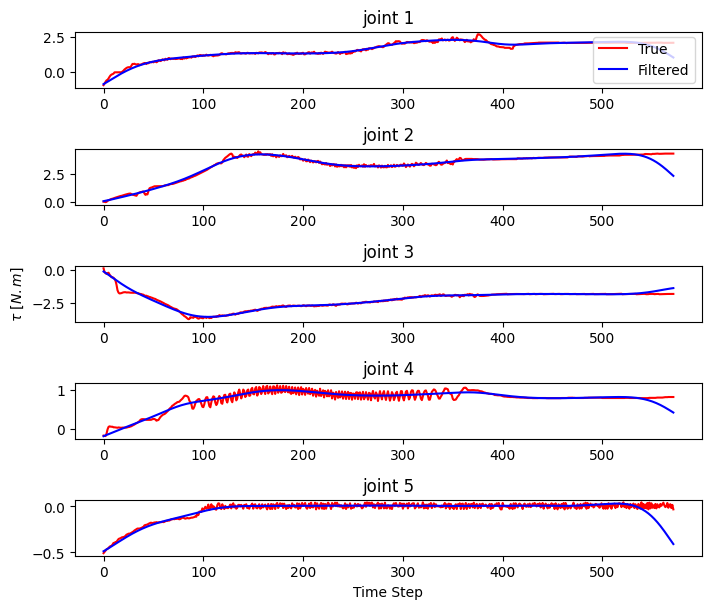

In [9]:
# Visualize original and filtered torque data on the first trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(Output_matrix[:trajectory_lengths[0], k], label='True', color='red')
  ax.plot(Output_matrix_filtered[:trajectory_lengths[0], k], label='Filtered', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

5. Split data into 8 trajectories for training, 2 for validation, and 2 for testing
- First 8 trajectories are for training
- Next two trajectories are for validation
- Last two trajectories are for testing

In [10]:
# Define the index of each set
Training_start, Training_end = 0, sum(trajectory_lengths[:-4])
Val_start, Val_end =  sum(trajectory_lengths[:-4]), sum(trajectory_lengths[:-2])
Testing_start, Testing_end = sum(trajectory_lengths[:-2]), sum(trajectory_lengths)

train_data, train_output = Data_matrix_filtered[Training_start:Training_end], Output_matrix_filtered[Training_start:Training_end]
val_data, val_output = Data_matrix_filtered[Val_start:Val_end], Output_matrix_filtered[Val_start:Val_end]
test_data, test_output = Data_matrix_filtered[Testing_start:Testing_end], Output_matrix_filtered[Testing_start:Testing_end]

In [11]:
# print the number of data samples in each set
print("Shape of train set:", train_data.shape, train_output.shape)
print("Shape of validation set:", val_data.shape, val_output.shape)
print("Shape of test set:", test_data.shape, test_output.shape)

Shape of train set: (5122, 10) (5122, 5)
Shape of validation set: (1636, 10) (1636, 5)
Shape of test set: (1755, 10) (1755, 5)


# Training

1. Define a fully connected neural network (FCNN) model


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout

def model():
    n_features = 10

    model = Sequential([
        Dense(150, activation='relu', input_shape=(n_features,)),
        Dropout(0.8),
        Dense(150, activation='relu'),
        Dropout(0.8),
        Dense(5, activation="linear")
    ])

    model.compile(loss='mse', optimizer='adam')

    return model

FC_NN = model()

2. Fit the model into training data

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

#Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

#Train the model with early stopping
history = FC_NN.fit(train_data, train_output, epochs=50, batch_size=16, validation_data=(val_data, val_output), callbacks=[early_stopping])

Epoch 1/50
321/321 [==============================] - 5s 4ms/step - loss: 2.3609 - val_loss: 1.3885
Epoch 2/50
321/321 [==============================] - 1s 3ms/step - loss: 1.1963 - val_loss: 1.3239
Epoch 3/50
321/321 [==============================] - 1s 3ms/step - loss: 0.9526 - val_loss: 1.4274
Epoch 4/50
321/321 [==============================] - 1s 3ms/step - loss: 0.8009 - val_loss: 1.3217
Epoch 5/50
321/321 [==============================] - 1s 3ms/step - loss: 0.7091 - val_loss: 1.1308
Epoch 6/50
321/321 [==============================] - 1s 3ms/step - loss: 0.6508 - val_loss: 1.0947
Epoch 7/50
321/321 [==============================] - 1s 4ms/step - loss: 0.6288 - val_loss: 1.1199
Epoch 8/50
321/321 [==============================] - 2s 5ms/step - loss: 0.5719 - val_loss: 1.1774
Epoch 9/50
321/321 [==============================] - 2s 5ms/step - loss: 0.5326 - val_loss: 0.9749
Epoch 10/50
321/321 [==============================] - 1s 3ms/step - loss: 0.5208 - val_loss: 1.0796

OR: load the saved model

In [14]:
FC_NN.load_weights('/content/drive/MyDrive/EECE789K-Project/FCNN_with_filtering.h5')

# Evaluation

1. Evaluate the model using MSE on train, validation, and test sets

In [15]:
# Get training and validation MSE
train_loss= FC_NN.evaluate(train_data, train_output)
val_loss = FC_NN.evaluate(val_data, val_output)
loss= FC_NN.evaluate(test_data, test_output)

print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)
print(f'Test Loss: {loss}')

55/55 [==============================] - 0s 2ms/step - loss: 1.3938
Train Loss: 0.16812725365161896
Validation Loss: 0.5627036094665527
Test Loss: 1.3937908411026


2. Plot the true and predicted torques on validation and test trajectories for the five joints

In [16]:
# Predict on the validation set

val_predictions = FC_NN.predict(val_data)
val_predictions.shape

52/52 [==============================] - 0s 2ms/step


(1636, 5)

In [17]:
# Predict on the test set

test_predictions = FC_NN.predict(test_data)
test_predictions.shape

55/55 [==============================] - 0s 1ms/step


(1755, 5)

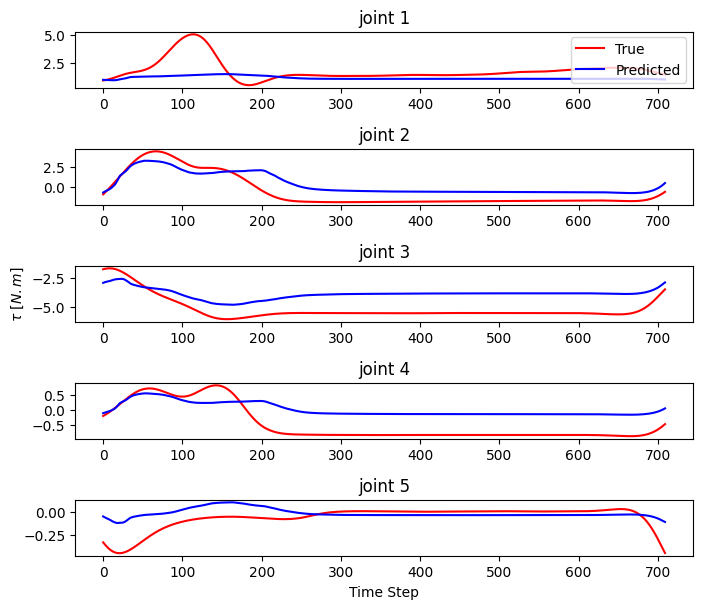

In [18]:
# Plot the output on the first validation trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[926:, k], label='True', color='red')
  ax.plot(val_predictions[926:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

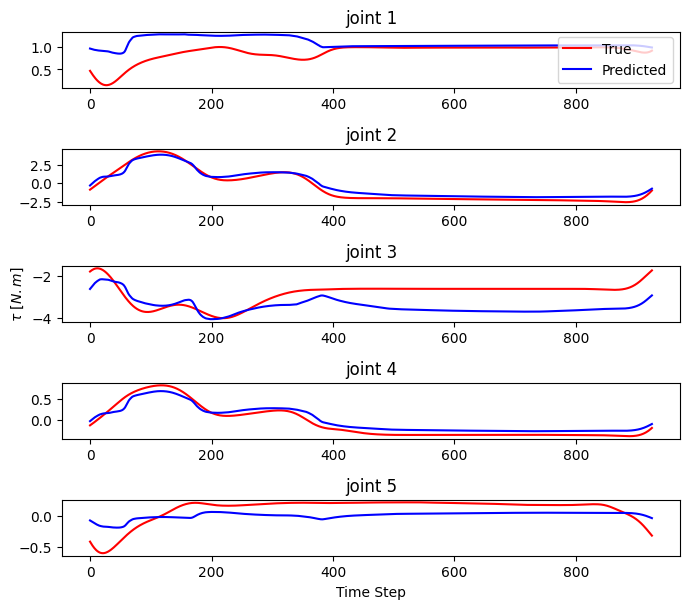

In [19]:
# Plot the output on the second validation trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[:926, k], label='True', color='red')
  ax.plot(val_predictions[:926, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

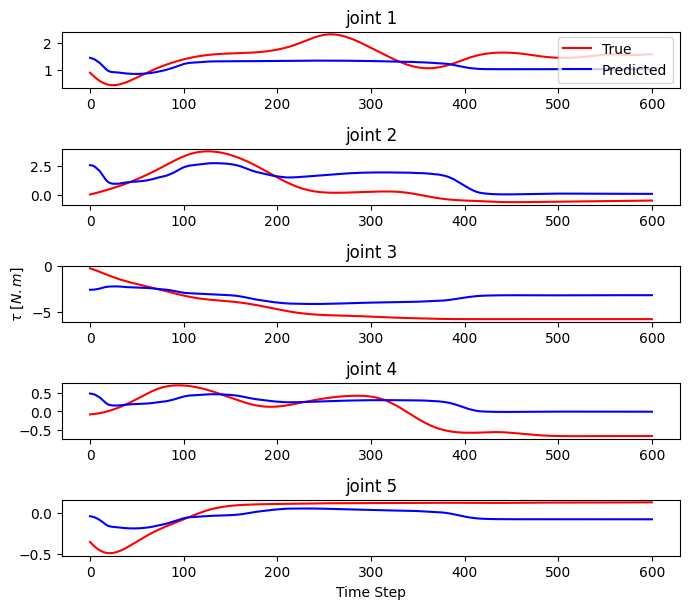

In [20]:
# Plot the output on the first test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[1154:, k], label='True', color='red')
  ax.plot(test_predictions[1154:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

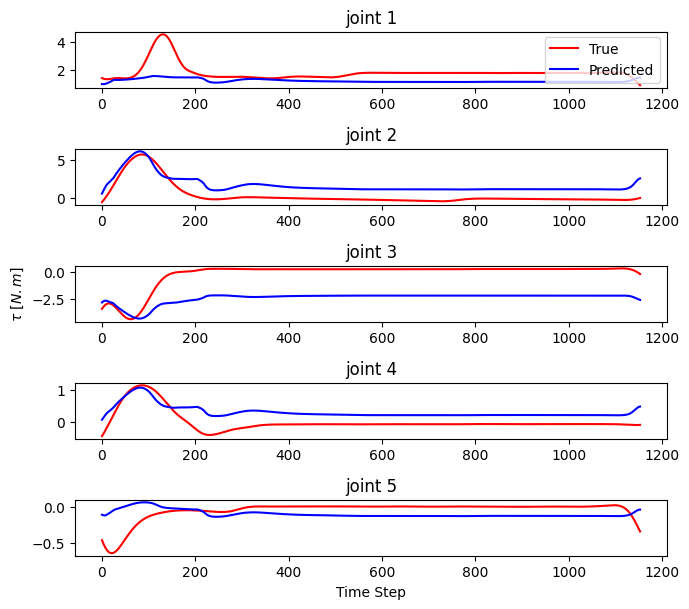

In [21]:
# Plot the output on the second test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[:1154, k], label='True', color='red')
  ax.plot(test_predictions[:1154, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

In [22]:
# Specify the path you need to save the model into
FC_NN.save('/content/drive/MyDrive/EECE789K-Project/FCNNN_with_filtering.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
